In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from functools import reduce
import matplotlib.pyplot as plt
# Matplotlib中设置字体-黑体，解决Matplotlib中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决Matplotlib坐标轴负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')

%matplotlib inline

# 数据

In [3]:
# 数据来自 http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant
df = pd.read_excel("./Folds5x2_pp.xlsx")

In [4]:
df.head(5)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [5]:
x, y = salary_df['AT'], salary_df['PE']
m = len(x)

# 相关系数

我们首先定义如下变量。

$$meanx = \bar{x}$$
$$meany = \bar{y}$$

In [6]:
meanx = sum(x) / m
meany = sum(y) / m
upper = sum( (x - meanx) * (y - meany) )
lower = (sum((x - meanx) ** 2) ** 0.5) * (sum((y - meany) ** 2) ** 0.5)

In [7]:
r = upper / lower
print(f"相关系数：{r}")

相关系数：-0.9481284704167581


# 线性回归方法一：解方程

在实现我们的公式前，首先将各个变量梳理一下。我们首先定义如下变量。

求 $\theta_0$ ：
$$xs1 = \sum_{i=1}^m x_i$$
$$xs2 = \sum_{i=1}^m x_i^2$$
$$ys1 = \sum_{i=1}^m y_i$$
$$ys2 = \sum_{i=1}^m y_i^2$$
$$xy = \sum_{i=1}^m x_i y_i$$

In [8]:
xs1 = sum(x)
xs2 = sum(x ** 2)
ys1 = sum(y)
ys2 = sum(y ** 2)
xy  = sum(x * y)
print(f"xs1 = {xs1}; xs2 = {xs2};\nys1 = {ys1}; ys2 = {ys2};\nxy = {xy};")

xs1 = 188022.9800000005; xs2 = 4226228.0792;
ys1 = 4347364.4100000085; ys2 = 1978076968.9818995;
xy = 84277343.00629972;


In [9]:
theta_0 = (xs2 * ys1 - xs1 * xy) / (m * xs2 - xs1 ** 2)
theta_1 = (m * xy - xs1 * ys1) / (m * xs2 - xs1 ** 2)

print(f'截距 theta_0：{theta_0}\n斜率 theta_1：{theta_1}')

截距 theta_0：497.0341198927946
斜率 theta_1：-2.171319958519148


# 线性回归方法二：网格搜索

我们进行如下设置：
```python
xlim0, xlim1, xcnt = 475, 525, 200
ylim0, ylim1, ycnt = -3, -1, 200
xstep, ystep = (xlim1 - xlim0) / xcnt, (ylim1 - ylim0) / ycnt
```

- 截距搜索范围都是 $[475, 525]$ ，步数 $200$ ，因此搜索步长自动计算为 $(525 - 475) / 200 = 0.25$
- 斜率搜索范围都是 $[-1, 1]$ ，步数 $200$ ，因此搜索步长自动计算为 $(-1 - (-3)) / 200 = 0.01$

因此这里会计算 $200 \times 200 = 40000$ 次。不宜把步数设置太多，这将导致程序一直在执行。

In [16]:
xlim0, xlim1, xcnt = 475, 525, 200
ylim0, ylim1, ycnt = -3, -1, 200
xstep, ystep = (xlim1 - xlim0) / xcnt, (ylim1 - ylim0) / ycnt

"""
这样搜索出的值未必是最优的
你可以试试调整上面这些参数
比如设置：
xlim0, xlim1, xcnt = 30, 40, 200
ylim0, ylim1, ycnt = 0, 0.2, 200
就是在 {30, 30.05, 30.10, ... , 40} 里搜索截距，在 {0, 0.001, 0.002, ... , 0.2} 里搜索斜率

注意，计算量与 xcnt 、 ycnt 成正比，如果这两个变量设置得太大，你的程序可能卡死在这里。
"""

def cal_error(theta_0, theta_1):
    return sum((theta_0 + theta_1 * x - y) ** 2)

best_theta_0, best_theta_1, best_error = 0, 0, 2e9
from tqdm import tqdm
for t1 in tqdm([xlim0 + i * xstep for i in range(xcnt + 1)]):
    for t2 in [ylim0 + i * ystep for i in range(ycnt + 1)]:
        error = cal_error(t1, t2)
        if error < best_error:
            best_error = error
            best_theta_0 = t1
            best_theta_1 = t2

print(f"best_error: {best_error}, best_theta_0: {best_theta_0}, best_theta_1: {best_theta_1}")

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:21<00:00,  9.33it/s]

best_error: 281604.0909868798, best_theta_0: 497.0, best_theta_1: -2.17


# 绘制曲线与散点图，计算对应误差值

梳理一下，顺序执行上面的代码，我们目前有：
- 数据：`x` `y`
- 用解方程得到的截距和斜率 `theta_0` `theta_1`
- 用搜索法得到的截距和斜率 `best_theta_0` `best_theta_1`

接下来利用 `theta_0 + theta_1 * y` 以及 `best_theta_0 + best_theta_1 * y` 分别绘图，并且计算误差值。

误差的方程是 $MSE = \sum_{i=1}^m (\theta_0 + \theta_1 x_i - y_i)$

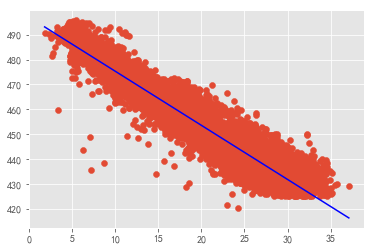

In [17]:
# 绘制解方程的图
# 为了绘制拟合的直线，首先定义直线两个端点 (xl, yl) (xr, yr)
xl, xr = min(x), max(x)
yl, yr = theta_0 + theta_1 * xl, theta_0 + theta_1 * xr

# 绘图
plt.scatter(x, y)
plt.plot([xl, xr], [yl, yr], c='b')

In [18]:
# 计算解方程的误差
print(f'解方程的误差: {cal_error(theta_0, theta_1)}')

解方程的误差: 281602.52484214277


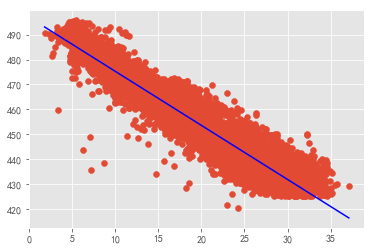

In [19]:
# 绘制搜索法的图
# 为了绘制拟合的直线，首先定义直线两个端点 (xl, yl) (xr, yr)
xl, xr = min(x), max(x)
yl, yr = best_theta_0 + best_theta_1 * xl, best_theta_0 + best_theta_1 * xr

# 绘图
plt.scatter(x, y)
plt.plot([xl, xr], [yl, yr], c='b')

In [20]:
# 计算搜索法的误差
print(f'搜索法的误差: {cal_error(best_theta_0, best_theta_1)}')

搜索法的误差: 281604.0909868798


# 敏感性分析：扰动参数观察误差值

所谓敏感性分析，就是将某个值固定，调整其他值，看目标函数的变化。

- 实验1：$\theta_0 = 497.03$，将 $\theta_1$ 在 $[-3, -1]$ 中变化，看 MSE 变化
- 实验2：$\theta_1 = -2.17$，将 $\theta_0$ 在 $[475, 525]$ 中变化，看 MSE 变化

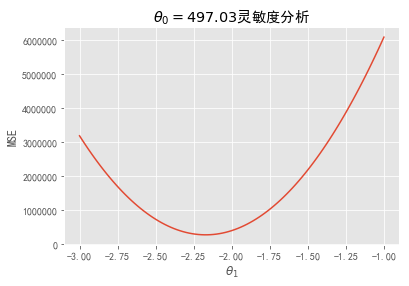

In [21]:
# 实验1
exp1_minx, exp1_maxx, exp1_cnt = -3, -1, 100  # 你可以修改这些值，看结果
exp1_theta_0 = 497.03 
exp1_theta_1s = [exp1_minx + i * (exp1_maxx - exp1_minx) / exp1_cnt for i in range(exp1_cnt + 1)]

mse_list = []
for exp1_theta_1 in exp1_theta_1s:
    error = cal_error(exp1_theta_0, exp1_theta_1)
    mse_list.append(error)

plt.plot(exp1_theta_1s, mse_list)
plt.xlabel('$θ_1$')
plt.ylabel('MSE')
plt.title(f'$θ_0 = {exp1_theta_0}$灵敏度分析')
plt.show()

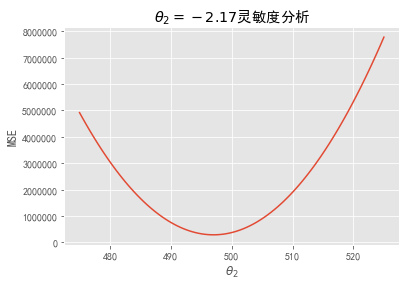

In [22]:
# 实验2
exp2_minx, exp2_maxx, exp2_cnt = 475, 525, 100  # 你可以修改这些值，看结果
exp2_theta_1 = -2.17
exp2_theta_0s = [exp2_minx + i * (exp2_maxx - exp2_minx) / exp2_cnt for i in range(exp2_cnt + 1)]

mse_list = []
for exp2_theta_0 in exp2_theta_0s:
    error = cal_error(exp2_theta_0, exp2_theta_1)
    mse_list.append(error)

plt.plot(exp2_theta_0s, mse_list)
plt.xlabel('$θ_2$')
plt.ylabel('MSE')
plt.title(f'$θ_2 = {exp2_theta_1}$灵敏度分析')
plt.show()

# 3D误差值

现在我们来绘制：

$$J(\theta) = \sum_{i=1}^m (\theta_0 + \theta_1 x_i - y_i)^2$$

这会是一个 3D 曲面，平面坐标系为 $\theta_0$ 与 $\theta_1$ ，高度（z轴）为 $J(\theta_0, \theta_1)$ 。

编程思路为：
- 首先确定范围， $\theta_0 \in [475, 525]$ ， $\theta_1 \in [-3, -1]$ ；
- 我们在这个 $(525 - 475) \times (-1 - (-1))$ 的平面上取 $200 \times 200$ 个点，分别计算其 MSE ，记录下来
- 然后就得到了一个 $\{(x_i, y_i, z_i)\}$ 集合，利用 python 自带库进行 3D 图形绘制就可以

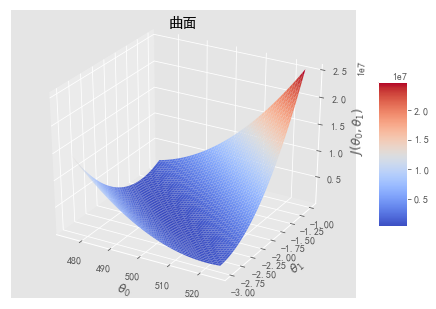

In [23]:
xlim0, xlim1, xcnt = 475, 525, 200  # 你可以自己修改这两行参数
ylim0, ylim1, ycnt = -3, -1, 200  # 你可以自己修改这两行参数
xstep, ystep = (xlim1 - xlim0) / xcnt, (ylim1 - ylim0) / ycnt

import numpy as np  # 需要用到 numpy 生成 200 * 200 个点
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# 网格
X = np.arange(xlim0, xlim1, xstep)
Y = np.arange(ylim0, ylim1, ystep)
X, Y = np.meshgrid(X, Y)
# 根据 x, y 计算 z
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        _x = X[0, i]
        _y = Y[j, 0]
        _z = cal_error(_x, _y)
        Z[i, j] = _z

# 曲面
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z,
                       cmap=cm.coolwarm,
                       linewidth=0)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel('$θ_0$')
plt.ylabel('$θ_1$')
ax.set_zlabel('$J(θ_0,θ_1)$')
plt.title('曲面')
plt.show()